In [1]:
# importing the packages
import pandas as pd


In [3]:
# Loading the data into the dataframes
dt_tag = pd.read_csv('data/tag.csv')
dt_rating = pd.read_csv('data/rating.csv')
dt_movie = pd.read_csv('data/movie.csv')
dt_link = pd.read_csv('data/link.csv')  
dt_genome_scores = pd.read_csv('data/genome_scores.csv')
dt_genome_tags = pd.read_csv('data/genome_tags.csv')  


# sampling 10% of the data in dt_tag to minimize the memory usage and to speed up the process
dt_tag = dt_tag.sample(frac=0.1, random_state=1)
dt_tag = dt_tag.rename(columns={'timestamp': 'tag_timestamp'})


In [4]:
# Merging the dataframes
dt = pd.merge(dt_tag, dt_rating, on=['userId', 'movieId'], how='inner')
dt = pd.merge(dt, dt_movie, on='movieId', how='inner')
dt = pd.merge(dt, dt_link, on='movieId', how='inner')
dt = pd.merge(dt, dt_genome_scores, on='movieId', how='inner')
dt = pd.merge(dt, dt_genome_tags, on=['tagId', 'tag'], how='inner')

print(dt.columns)

Index(['userId', 'movieId', 'tag', 'tag_timestamp', 'rating', 'timestamp',
       'title', 'genres', 'imdbId', 'tmdbId', 'tagId', 'relevance'],
      dtype='object')


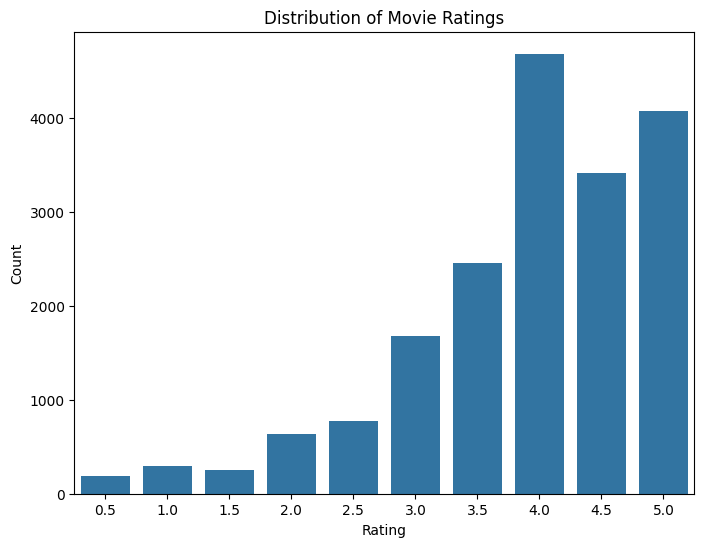

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.countplot(x='rating', data=dt)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


/var/folders/by/z4t2j23n5qb8_7scg2s_mjg00000gn/T/ipykernel_14596/3356505072.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='rating_count', y='title', data=top_movies, palette='viridis')


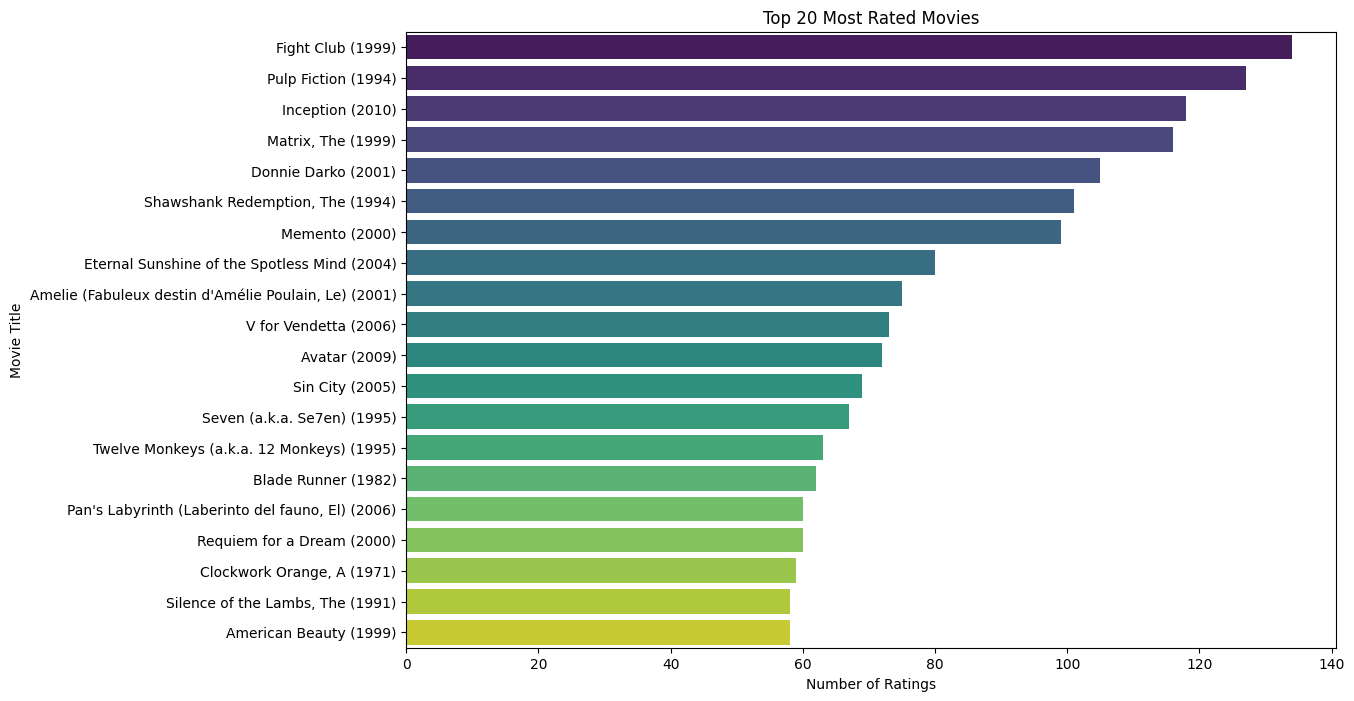

In [7]:
# Top 20 most rated movies
top_movies = dt['movieId'].value_counts().head(20).reset_index()
top_movies.columns = ['movieId', 'rating_count']
top_movies = top_movies.merge(dt[['movieId', 'title']], on='movieId')

plt.figure(figsize=(12,8))
sns.barplot(x='rating_count', y='title', data=top_movies, palette='viridis')
plt.title('Top 20 Most Rated Movies')
plt.xlabel('Number of Ratings')
plt.ylabel('Movie Title')
plt.show()


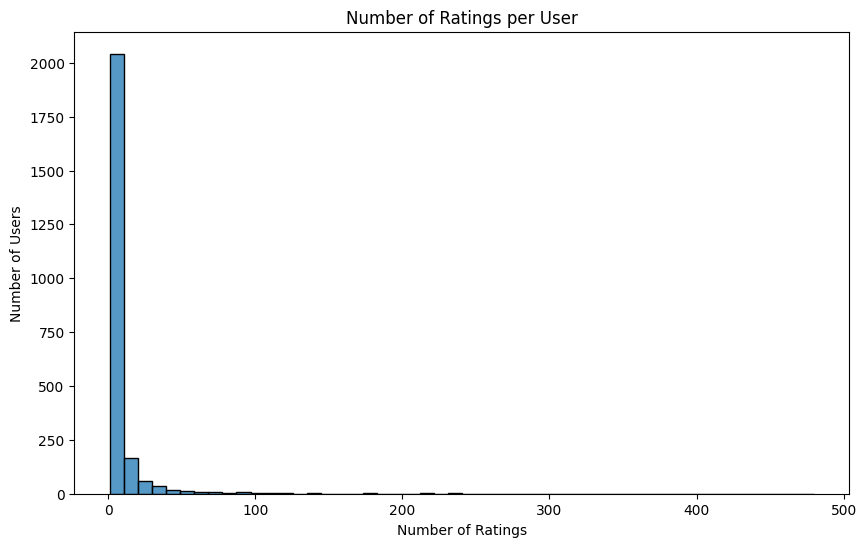

In [8]:
user_rating_counts = dt['userId'].value_counts()

plt.figure(figsize=(10,6))
sns.histplot(user_rating_counts, bins=50, kde=False)
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.show()


/var/folders/by/z4t2j23n5qb8_7scg2s_mjg00000gn/T/ipykernel_14596/2069072204.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='genre', data=genre_counts, palette='coolwarm')


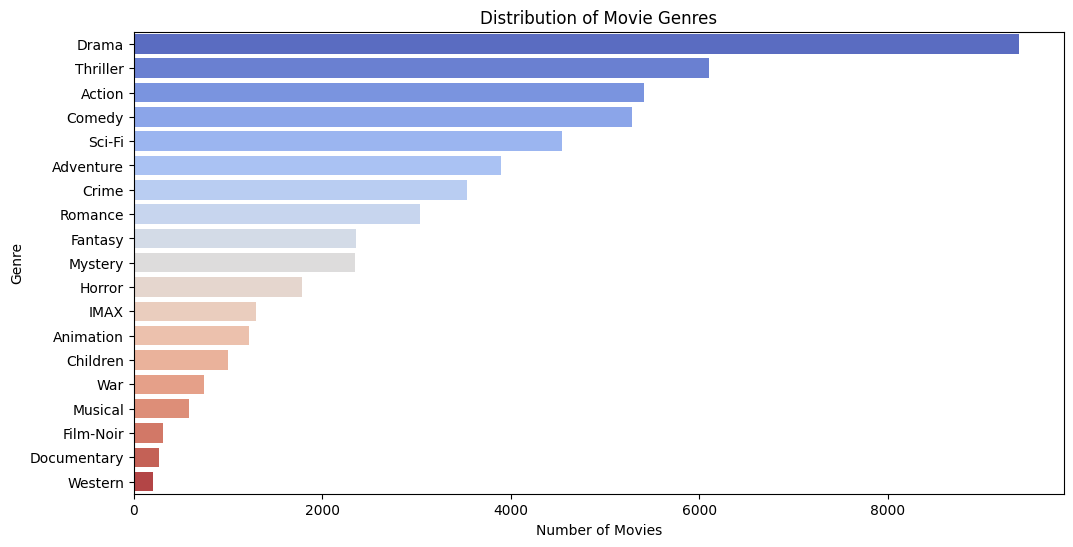

In [10]:
# Split genres and count
genres = dt['genres'].str.get_dummies(sep='|')
genre_counts = genres.sum().sort_values(ascending=False).reset_index()
genre_counts.columns = ['genre', 'count']

plt.figure(figsize=(12,6))
sns.barplot(x='count', y='genre', data=genre_counts, palette='coolwarm')
plt.title('Distribution of Movie Genres')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.show()


/var/folders/by/z4t2j23n5qb8_7scg2s_mjg00000gn/T/ipykernel_14596/1025126462.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='tag', data=top_tags, palette='magma')


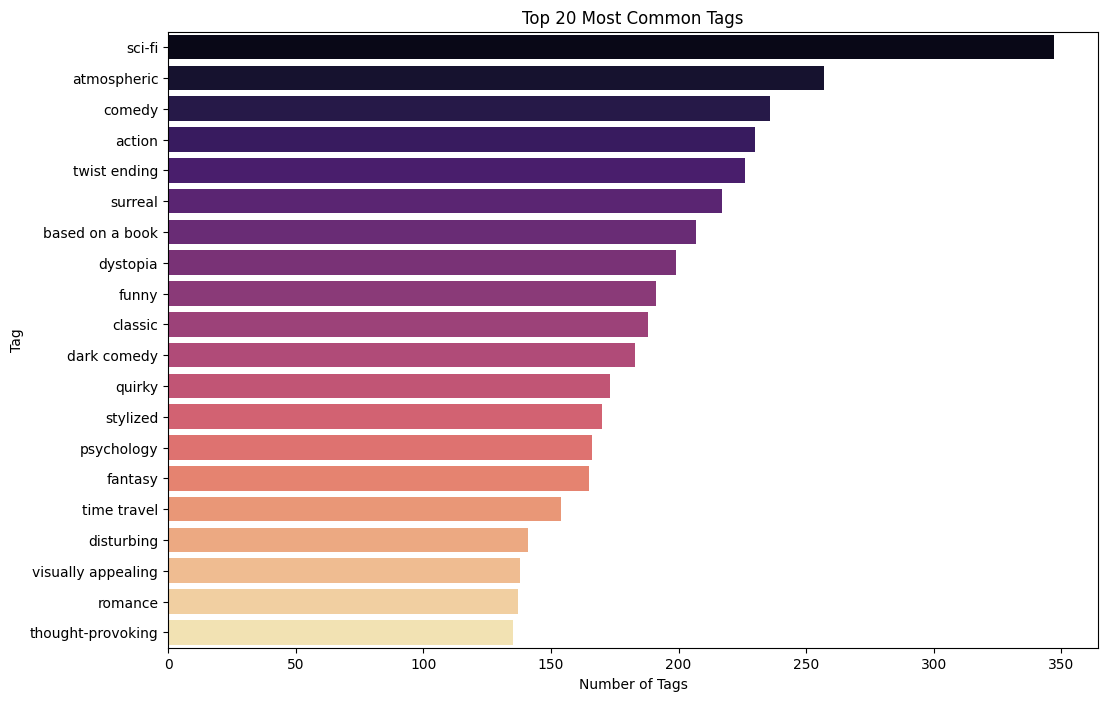

In [12]:
top_tags = dt['tag'].value_counts().head(20).reset_index()
top_tags.columns = ['tag', 'count']

plt.figure(figsize=(12,8))
sns.barplot(x='count', y='tag', data=top_tags, palette='magma')
plt.title('Top 20 Most Common Tags')
plt.xlabel('Number of Tags')
plt.ylabel('Tag')
plt.show()


In [14]:
print(dt['timestamp'].head())
print(dt['timestamp'].dtype)


0    2014-05-01 21:59:03
1    2015-02-01 00:12:05
2    2009-02-10 01:52:13
3    2012-12-15 17:57:01
4    2013-09-03 16:07:46
Name: timestamp, dtype: object
object


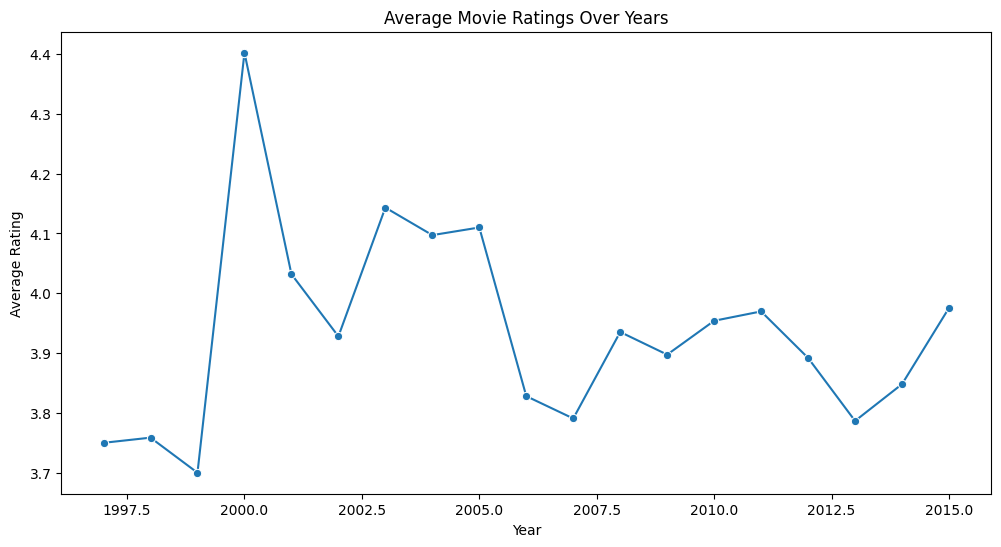

In [15]:



# Convert 'timestamp' to datetime
dt['timestamp'] = pd.to_datetime(dt['timestamp'])

# Extract the year from the timestamp
dt['year'] = dt['timestamp'].dt.year

# Calculate average rating per year
avg_ratings_year = dt.groupby('year')['rating'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(x='year', y='rating', data=avg_ratings_year, marker='o')
plt.title('Average Movie Ratings Over Years')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.show()


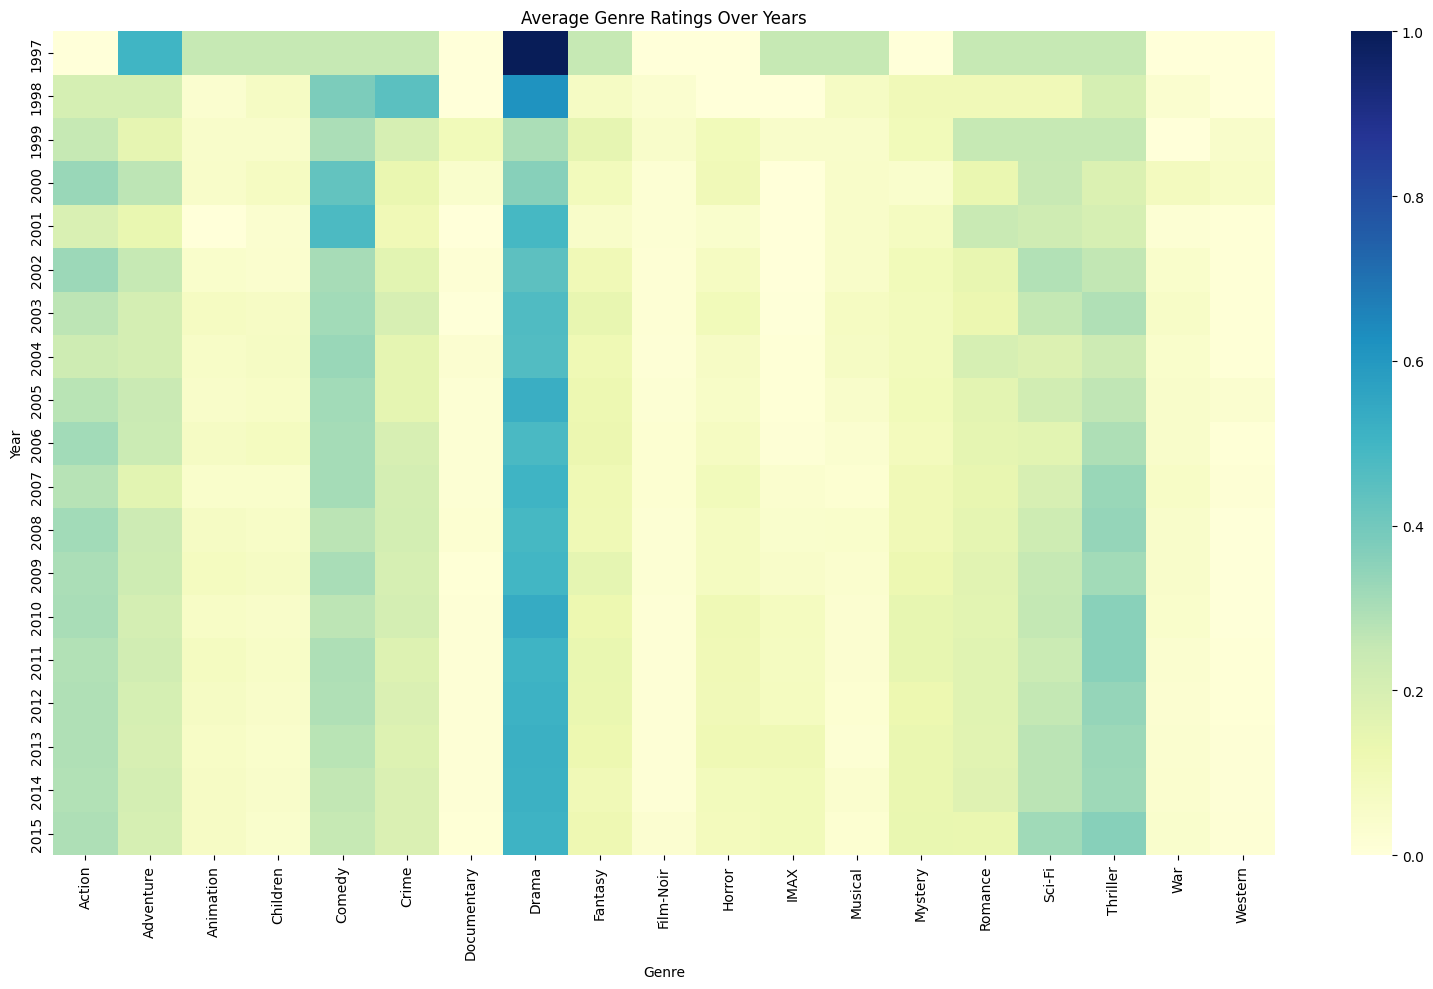

In [16]:
# Split genres and create dummy variables
genres_split = dt['genres'].str.get_dummies(sep='|')

# Merge with the main DataFrame
dt_with_genres = pd.concat([dt, genres_split], axis=1)

# Calculate average rating per year per genre
genre_year_rating = dt_with_genres.groupby('year')[genres_split.columns].mean()

# Plot the heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(genre_year_rating, cmap='YlGnBu', annot=False)
plt.title('Average Genre Ratings Over Years')
plt.xlabel('Genre')
plt.ylabel('Year')
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.decomposition import PCA

# Assuming movie_features_normalized is your feature matrix
pca = PCA(n_components=2)
pca_components = pca.fit_transform(movie_features_normalized)

pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
pca_df['movieId'] = movie_features_normalized.index

# Merge with cluster labels
pca_df = pca_df.merge(movie_clusters_kmeans, on='movieId')

plt.figure(figsize=(12,8))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', palette='tab20', data=pca_df, legend='full', alpha=0.6)
plt.title('PCA Scatter Plot of Movies Colored by Cluster')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [ ]:
plt.figure(figsize=(8,6))
sns.histplot(genome_scores['relevance'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Genome Tag Relevance Scores')
plt.xlabel('Relevance Score')
plt.ylabel('Frequency')
plt.show()


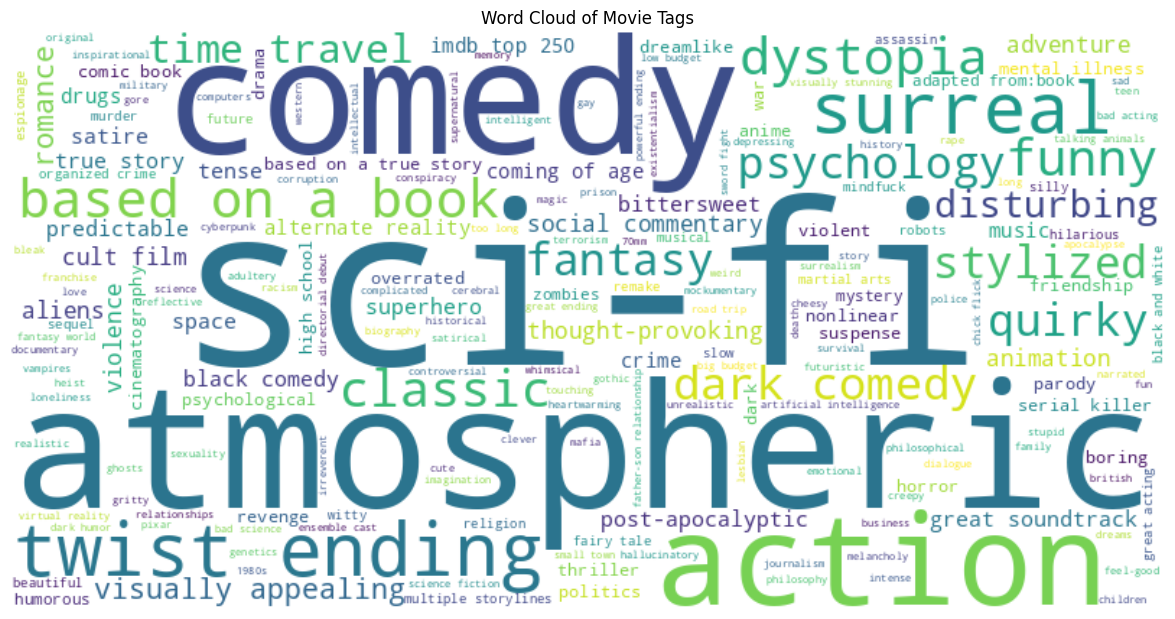

In [13]:
from wordcloud import WordCloud

# Generate word frequencies
tag_freq = dt['tag'].value_counts().to_dict()

# Create word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tag_freq)

plt.figure(figsize=(15,7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Movie Tags')
plt.show()
